# Overview and Discussion of Neural Receiver Architectures

This notebook gives an overview of the neural receiver architecture and explains its main design decisions.
The architecture was introduced in [[1]](#references) and consists of the following elements:
- Convolutional neural network (CNN) layers over the time-frequency grid
- Graph neural network (GNN) inspired multi-user interference cancellation scheme
- Readout network to project the feature space back to the desired output domain (LLRs and channel estimates)

A particular focus is put on the 5G NR compatibility and the possibility for real-time inference.
This imposes a couple of constraints on the size and depth of the neural networks
A carefully optimized set of parameters ensures a good tradeoff between BLER performance and inference latency.

Key features of the architecture are:
- 5G NR multi-user (MU) MIMO compatible & support for flexible number of active users without re-training
- Processing of entire *slots* (i.e., an entire time/frequency grid with 14 consecutive OFDM symbols with up to 3276 subcarriers)
- Support for varying DMRS pilots (by feeding an initial channel estimate)
- Flexibility w.r.t. different number of allocated PRBs without retraining
- Support for MU-MIMO, i.e., multiple transmitters and multiple receive antennas
- Dynamic re-configurable MCS schemes without the need for re-training.


We recommend the [Jumpstart Tutorial Notebook](jumpstart_tutorial.ipynb) as an introduction to the training framework.

An overview of the network layers is given in the figure below. Please note that a few minor steps are ignored to simplify the visualization.
The network implements a similar functionality as the [Sionna PUSCHReceiver](https://nvlabs.github.io/sionna/api/nr.html#puschreceiver) and directly returns the reconstructed payload bits of the transport block. However, the LDPC decoder and rate-matching is done by a *classical* [transport block decoder](https://nvlabs.github.io/sionna/api/nr.html#tbdecoder) layer and is, thus, not trainable.

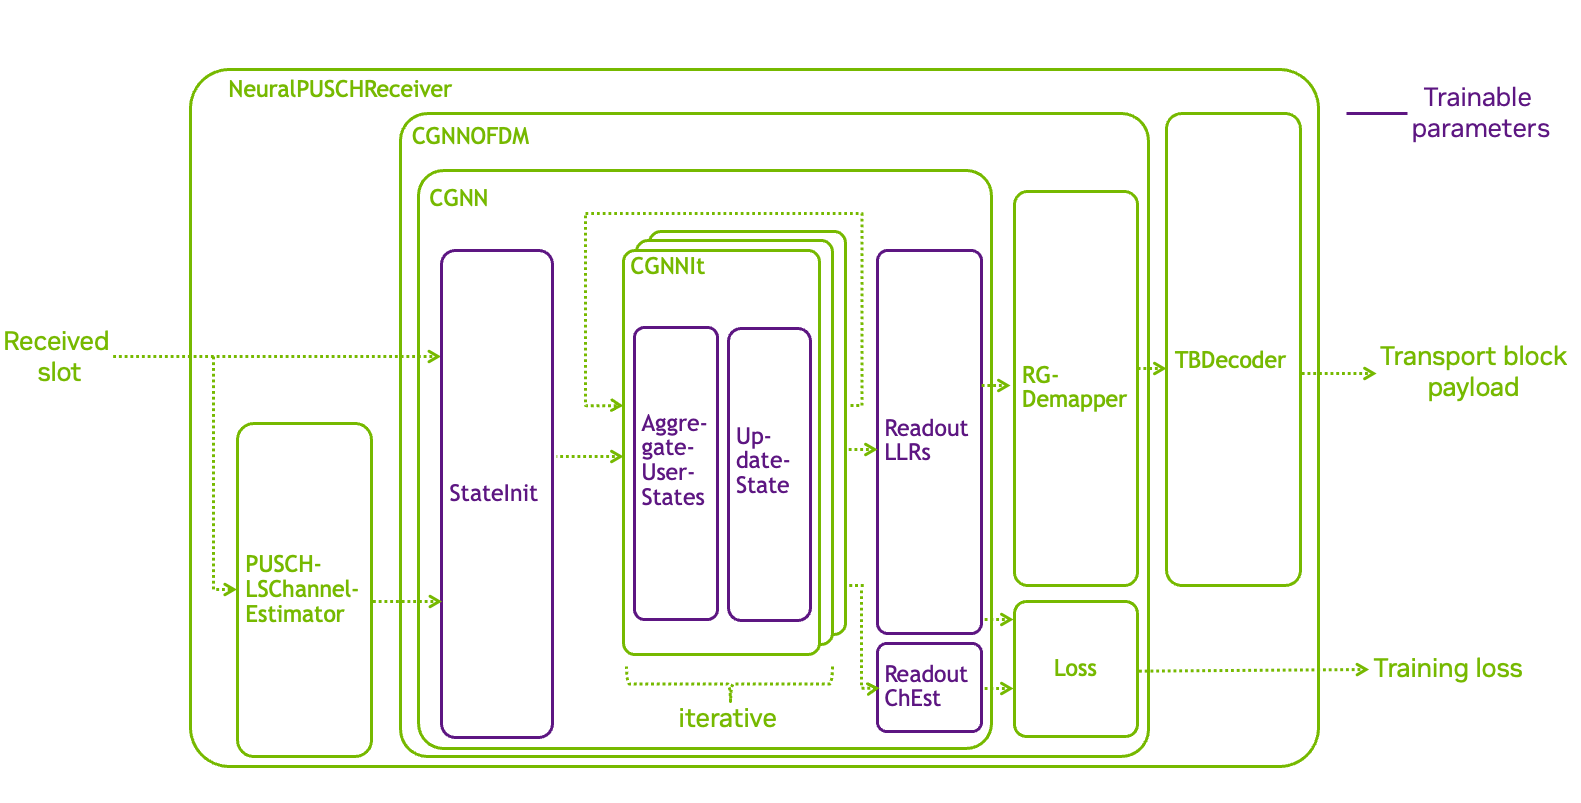

As can be seen in the system overview above, the core component is the `CGNN` layer (convolutional & graph neural network) which basically processes the time/frequency grid. However, it requires additional wrappers to bring the inputs/outputs in a 5G NR compatible format.

## Table of Contents
* [General Architecture Overview](#General-Architecture-Overview)
* [Basic Neural Network Architecture](#Basic-Neural-Network-Architecture)
* [5G NR Compatibility Aspects](#5G-NR-Compatibility-Aspects)
* [Single vs. Multi-user Receiver](#Single-vs.-Multi-user-Receiver)
* [Real-time Inference Constraints](#Real-time-Inference-Constraints)
* [References](#References)


## General Architecture Overview

The detailed receiver algorithm is described in [[1]](#references) and can be summarized as follows.

The NRX takes as input:
- Received signal of slot $\mathbf{Y}$
- Initial channel estimate (e.g., from least square (LS) channel estimation) $\hat{\mathbf{H}}$ for each user
- Positional encoded pilot positions in time/frequency grid $\mathbf{P}$
- *Optional*: Noise variance estimate; we observe that this is typically not required

A particular focus of the NRX architecture was put on the flexibility w.r.t. changing number of PRBs without the need for any retraining.

*Remark:* In 5G NR, each user – possibly equipped with multiple antennas –
can be configured to transmit multiple MIMO layers (or data streams).
For readability, we denote every layer as an independent transmitter in the
following description. The proposed neural receiver architecture supports
multiple layers per user by treating every stream as a (virtual) user.


As illustrated in the figure below, the receiver consists of the following stages:

1. Initial convolutional neural network (CNN) that projects the stacked input to a high dimension feature space $\mathbf{S}^{(0)}$
2. Pointwise MLP and aggregation between the resource elements (REs) of all users (*multi-user interference cancellation*)
3. CNN over the time/frequency grid (implemented with separable convolutions and skip connections)
4. Readout MLP to project the internal state $\mathbf{S}^{(N_{it})}$ back to (scalar) LLRs

Steps 2 and 3 are iteratively repeated, which effectively defines the depth of the receiver and, thereby, enables a simple computational complexity adjustment.

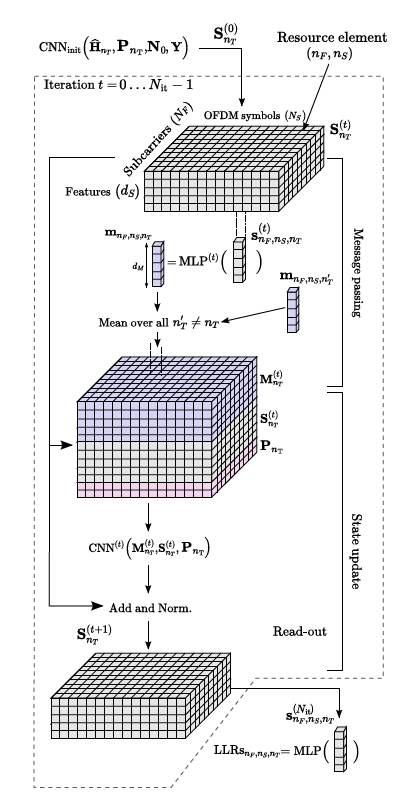

The *message passing* part is inspired by the concept of graph neural networks (see [GNN decoder](https://github.com/NVlabs/gnn-decoder) for details). Essentially, every state vector of every resource element (RE) in every user's time/frequency grid is processed by a small MLP and the states of all users are aggregated afterwards. This comes with the advantage that users can join or leave the network without the need for retraining.

The *state update* part is done for each user individually and effectively runs CNN layers over the time/frequency grid. We additionally stack the initial channel estimates and the positional encoding of the pilot positions (as reliability measure of the initial channel estimates). This part is very similar to the architecture used in the [Sionna Neural Receiver tutorial notebook](https://nvlabs.github.io/sionna/examples/Neural_Receiver.html).

Intuitively, multi-user interference cancellation is done by the MLP layers followed by the aggregation of the user states (*message passing stage*).

## GPU Configuration and Imports

In [1]:
# import relevant packages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tf warnings

gpu_num = 0 # Number of the GPU to be used
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import sys
sys.path.append('../') # to access all relevant repo files

%load_ext autoreload
%autoreload 2

from utils import E2E_Model, Parameters, load_weights, plot_results
import numpy as np
import matplotlib.pyplot as plt

Number of GPUs available : 2
Only GPU number 0 used.


## Basic Neural Network Architecture

The magenta blocks in the system overview figure above denote trainable components (i.e., neural networks) and the green blocks are Sionna components that are non-trainable (e.g., the LDPC decoder).

We are using separable convolutions and fully connected layers both with ReLU activations.

In [2]:
config_name = "nrx_rt.cfg" # define config file which includes the NRX architecture definition

# load the model
sys_parameters = Parameters(config_name,
                            training=False,
                            system='nrx')
model = E2E_Model(
            sys_parameters,
            training=False,
            return_tb_status=False) # if True, the NRX returns the TB CRC check

Evaluating the first 2 port sets
Loading DoubleTDL with low correlation.


And let's have a look at the number of trainable parameters.

In [3]:
model(1,1.); # dummy run to initialize the model

# use Keras default functions to summarize the model
model.summary()

Model: "e2e__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source (BinarySourc  multiple                  0         
 e)                                                              
                                                                 
 pusch_transmitter (PUSCHTr  multiple                  0         
 ansmitter)                                                      
                                                                 
 double_tdl_channel (Double  multiple                  0         
 TDLChannel)                                                     
                                                                 
 neural_pusch_receiver (Neu  multiple                  142922    
 ralPUSCHReceiver)                                               
                                                                 
Total params: 142922 (558.29 KB)
Trainable params: 14292

As shown in the overview figure above, the model is composed of multiple sub-layers. 

Let's now focus on the NN part, which is defined by the `CGNN` class.

In [4]:
# and the NeuralPUSCHReceiver can be directly access
model._receiver._neural_rx._cgnn.summary()

Model: "cgnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state_init (StateInit)      multiple                  28634     
                                                                 
 cgnn_it (CGNNIt)            multiple                  49074     
                                                                 
 cgnn_it_1 (CGNNIt)          multiple                  49074     
                                                                 
 readout_ll_rs (ReadoutLLRs  multiple                  7812      
 )                                                               
                                                                 
 readout_ch_est (ReadoutChE  multiple                  8328      
 st)                                                             
                                                                 
Total params: 142922 (558.29 KB)
Trainable params: 142922 (558

As can be seen, the current architecture has two internal iterations, which keeps the inference latency reasonable.
Overall, the NRX has only ~143k trainable parameters. Every additional iteration would roughly add 49k additional weights (assuming the same network dimensions).

Details can be configured in the config file. Hereby, the following parameters are used to define the above receiver:

- `num_nrx_iter = 2` defines number of `cgnn_it` stages
- `num_nrx_iter_eval = 2` iterations used for evaluation; must be <= `num_nrx_iter`
- `d_s = 56` feature space dimensions
- `num_units_init = [128, 128]` number of filter kernels of the input CNN (each list entry defines one layer)
- `num_units_agg = [[64], [64]]` number of neurons of state aggregation MLP (each list entry defines one layer; outer list separates iterations, inner list defines layers in iteration)
- `num_units_state = [[128, 128], [128, 128]]` number of filter kernels for stage update CNN (each list entry defines one layer; outer list separates iterations, inner list defines layers in iteration)
- `num_units_readout = [128]` number of neurons of state aggregation MLP (each list entry defines one layer)

We also provide a configuration for a deeper neural receiver with a larger depth (`num_rx_iter`) of 8 (opposed to the previous configuration with depth 2).

In [5]:
config_name_large = "nrx_large.cfg" # define config file which includes the NRX architecture definition

# load the model
sys_parameters_large = Parameters(config_name_large,
                            training=False,
                            system='nrx')
model_large = E2E_Model(
            sys_parameters_large,
            training=False,
            return_tb_status=False) # if True, the NRX returns the TB CRC check

model_large(1,1.); # dummy run to initialize the model

# use Keras default functions to summarize the model
model_large.summary()

Evaluating the first 2 port sets
Loading DoubleTDL with low correlation.
Model: "e2e__model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source_1 (BinarySou  multiple                  0         
 rce)                                                            
                                                                 
 pusch_transmitter_1 (PUSCH  multiple                  0         
 Transmitter)                                                    
                                                                 
 double_tdl_channel_1 (Doub  multiple                  0         
 leTDLChannel)                                                   
                                                                 
 neural_pusch_receiver_1 (N  multiple                  437366    
 euralPUSCHReceiver)                                             
                                               

Note that one can reduce the depth after training, which effectively discards the last layers at the cost of a (possibly) degraded BLER performance.
The `num_iter` parameter offers a straightforward way to control the trade-off between BLER performance and inference latency. However, one cannot make the NRX deeper as originally trained, as otherwise untrained NN components would be added. 

In [6]:
print("Current number of CGNN iterations: ",
      model_large._receiver._neural_rx._cgnn.num_it)

# and set to 2
model_large._receiver._neural_rx._cgnn.num_it = 2

print("New number of CGNN iterations: ",
      model_large._receiver._neural_rx._cgnn.num_it)

Current number of CGNN iterations:  8
New number of CGNN iterations:  2


##  5G NR Compatibility Aspects

5G NR introduces a few standard specific aspects that require careful considerations in the receiver and training pipeline.

We are using a pilot pattern with two DMRS symbols. However, that could be modified in the config file.

Evaluating the first 2 port sets


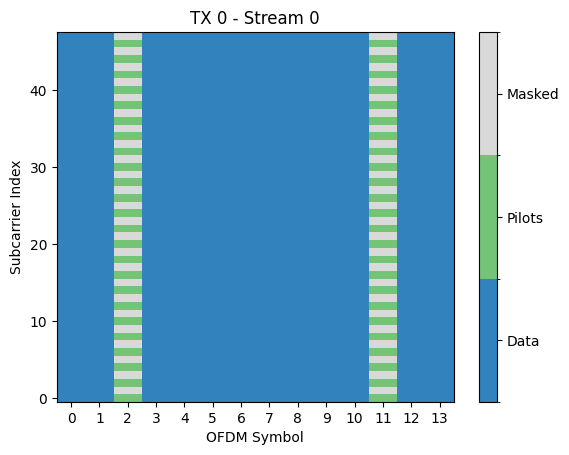

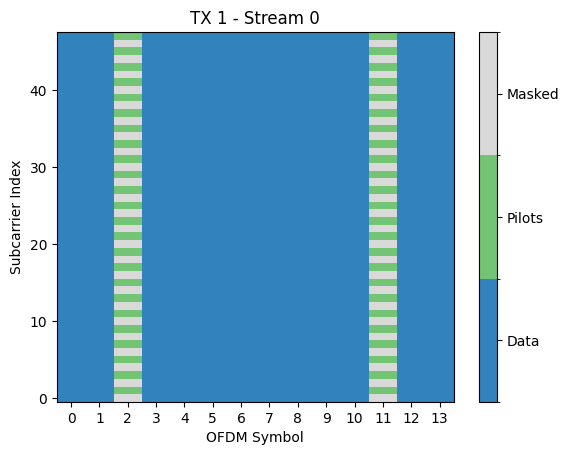

In [7]:
# We load the training parameters, as they have less PRBs which makes the
# following visualization simpler.
sys_parameters_training = Parameters(config_name,
                                     training=True,
                                     system='nrx')
sys_parameters_training.transmitters[0].pilot_pattern.show();

*Remarks:* in the current configuration, DMRS ports 0 and 2 are used. This results in orthogonal (i.e., non-overlapping) pilots. However, the neural receiver can be also trained for overlapping pilots (e.g., DMRS port 0 and 1).

### Dynamic DMRS values

The values of the DMRS symbols depend on the `slot-id` (only the value of the pilot not their position). 
This implies that the pilots are effectively phase-rotated after every transmitted slot and learning the values of the pilots becomes challenging for the NRX.
As a result one could train individual receivers for each `slot-id`, but this approach obviously does not scale.

A pre-processing stage to rotate the pilots before decoding is an option, however, becomes challenging in a multi-user setup.

Instead, we feed least-squares (LS) channel estimates as input to the neural receiver. 
These are obtained by an outer least-squares (LS) channel estimator which provides the initial channel estimate
for each user (i.e., per active DMRS port). Simple nearest neighbor interpolation is used to generate initial channel estimates over the entire resource grid.

As the NRX does not know the position of the DMRS (and it could change depending on the exact PUSCH configuration), we feed as additional input
a positional encoding of the nearest pilot position for all REs.

During training, the DMRS values are randomized to train a universal and robust NRX. This is strictly speaking not 5G NR compliant, however, only happens during training and the 5G NR pilot values are a subset of the training scenario. We empirically found this to be sufficient to deal with varying 5G NR compliant DMRS pilots.

An extension is to also randomize the pilot positions during training, which would allow to reconfigure the DMRS positions on-the-fly.
However, this is currently not implemented for simplicity.

### DMRS Ports

In 5G NR, the multi-user / multi-stream aspect boils down to the selection of DMRS ports.
For this, we configure the NRX to have a maximum number of active DMRS ports and during the interference, we select the active DMRS ports.
This means that during the state aggregation, each input is multiplied with the `dmrs_port_mask` (takes either 0 or 1 as value).
If a port is deactivated (`dmrs_port_mask[i]==0`), the state updates of this port/user have no effect on the other processing results of the other users.

In the current TensorFlow and TensorRT implementation this implies that all layers are processed for every inference (even if the DMRS port is currently non-active). 
From a computational complexity perspective, this could be optimized such that only active layers are executed. However, this does not effect the BLER performance of the receiver as non-active results are simply ignored.

During training we randomly sample the number of active users following a *triangular distribution*, i.e., we sample more cases with many users as these are intuitively harder to learn.

*Remark:* there is a small difference between having multiple layers per UE and having layers from multiple UEs.
For the first case, the effective physical MIMO channel is the same for all layers, but each layer applies a different precoding vector. For the second scenario, each stream experiences a different physical channel. However, this effect is neglected in this NRX implementation.

## Single vs. Multi-user Receiver

A subset of the receiver architecture can be used for single and multi-user systems. When `max_num_tx` is set to 1, the state aggregation becomes inactive and the entire NRX architecture becomes similar to the one used in the [Sionna NRX tutorial notebook](https://nvlabs.github.io/sionna/examples/Neural_Receiver.html).

The resulting single-user architecture is fully CNN-based which lowers the computational complexity (and training complexity) significantly.

The main challenge of a multi-user architecture is the flexibility and reconfigurability. The advantage of the state aggregation stage is that it can be easily reconfigured to a new set of active DMRS ports. 


## Real-time Inference Constraints

For practical deployment of the system, the inference latency must be reasonable. The exact latency requirements are application and hardware specific, however, we target 1 ms for our architecture optimization which imposes constraints on the depth of the network as well as the number of neurons/kernels per layer. 

We restrict the batch size for deployment to 1 as buffering of received slots would be required otherwise (or multiple receivers must run in parallel).

Besides the available hardware platform, the main factors for inference latency are the number of PRBs, number of users and number of receive antennas.
It is therefore an application specific choice of the receiver parameters for a given 5G NR system configuration.

For latency measurements, we refer to the [Real-time NRX Tutorial notebook](real_time_nrx.ipynb) which exports the receiver to a TensorRT engine.
This allows for significantly lower execution times compared to the TensorFlow implementation. 

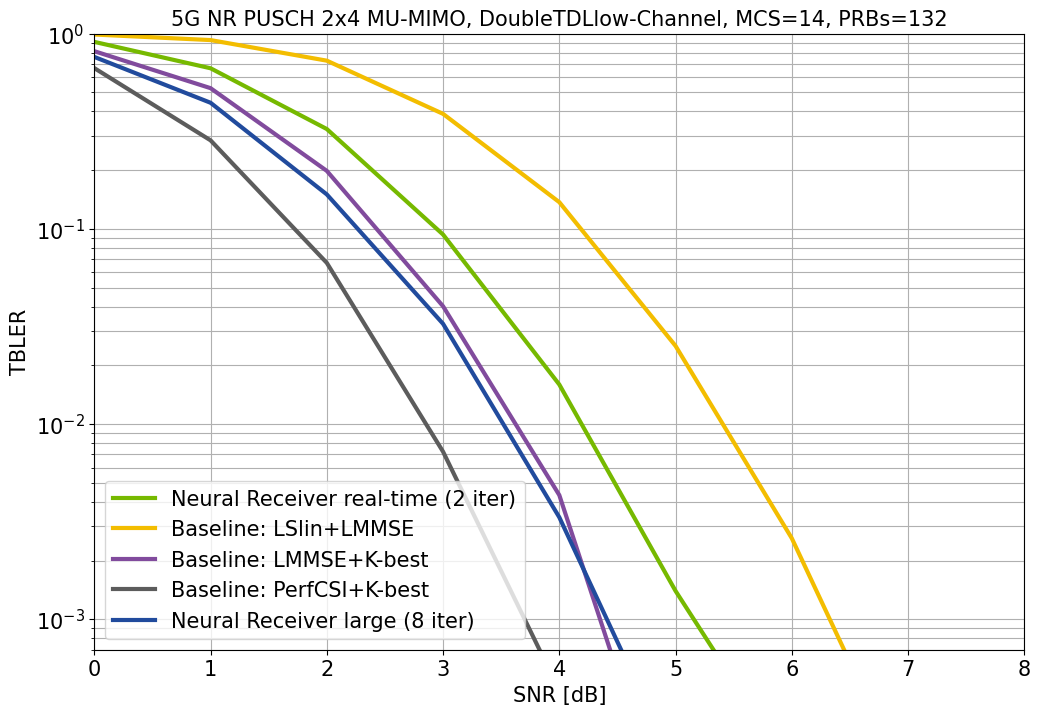

In [8]:
num_tx_eval = 2 # depends on what has been evaluated in evaluate.py before

fig = plot_results(config_name, num_tx_eval=num_tx_eval,
                   xlim=[0,8], ylim=[7e-4,1],
                   labels=["Neural Receiver real-time (2 iter)",
                           "Baseline: LSlin+LMMSE",
                           "Baseline: LMMSE+K-best",
                           "Baseline: PerfCSI+K-best"]);
plot_results(fig=fig, config_name="nrx_large.cfg", num_tx_eval=num_tx_eval,
             xlim=[0,8], ylim=[7e-4,1], color_offset=4,
             labels=["Neural Receiver large (8 iter)"]);

As can be seen in the BLER curves above, the larger NRX model achieves a better BLER performance.
However, the inference latency is approx. 3x larger which might become prohibitive in some scenarios.

We now sweep over the depth of the NRX by modifying the `num_iter` parameter during evaluation.
The NRX was trained for 8 iterations with multiloss, i.e., during training the loss is averaged over all iterations.

Please note that the numbers below where simulated on an NVIDIA A100 80GB for 2 users and 132 PRBs.
The latency measurements are for the corresponding TensorRT engine (see [real time neural receiver notebook](real_time_nrx.ipynb) for details).

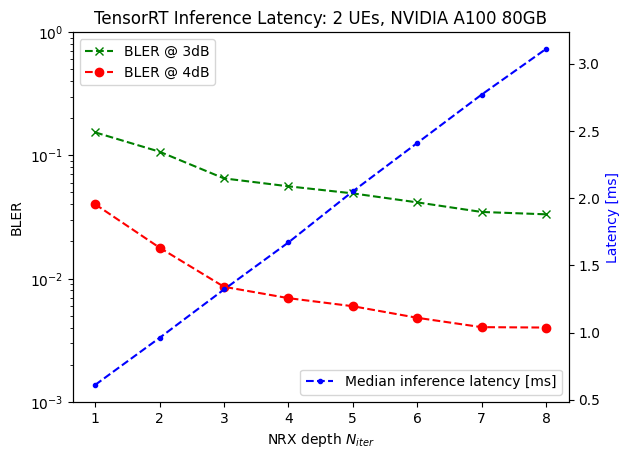

In [9]:
# We sweep over 1-8 iterations for the nrx_large.cfg architecture

# latency measurements are from the onnx export script, i.e., measured via TensorRT
latency = [0.61, 0.97, 1.33, 1.69, 2.06, 2.42, 2.78, 3.14]        # A100 80GB, mean runtime
latency = [0.61, 0.96, 1.32, 1.67, 2.05, 2.41, 2.77, 3.11]        # A100 80GB, median runtime

#BLER @ 3dB
bler1 = [1.536e-1, 1.07e-1, 6.499e-2, 5.604e-2, 4.91e-2, 4.15e-2, 3.47e-2,3.32e-2]
#BLER @ 4 dB
bler2 = [4.01e-2, 1.78e-2, 8.57e-3, 6.93e-3, 5.96e-3, 4.8e-3,4.03e-3,4.00e-3]

x = np.arange(1,len(latency)+1)

# Create the first plot
fig, ax1 = plt.subplots()

ax1.semilogy(x, bler1, 'g', marker="x", linestyle="dashed", label="BLER @ 3dB")  # Plot y1 with green solid line
ax1.semilogy(x, bler2, 'r', marker="o", linestyle="dashed", label="BLER @ 4dB")  # Plot y1 with green solid line
ax1.set_xlabel('NRX depth $N_{iter}$')
ax1.set_ylabel('BLER')
ax1.set_ylim([1e-3, 1.])
#ax.set_xlim[]

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(x, latency, 'b', marker=".", linestyle="dashed", label="latency")  # Plot y2 with blue solid line
ax2.set_ylabel('Latency [ms]', color='b')

# Set the title
plt.title('TensorRT Inference Latency: 2 UEs, NVIDIA A100 80GB')

# Show the plot
ax1.legend(["BLER @ 3dB", "BLER @ 4dB"], loc='upper left')
ax2.legend(["Median inference latency [ms]"], loc='lower right')

plt.show();


If we instead evaluate the minimum SNR required to achieve a target BLER of 10% (SNR@BLER=1e-1). We compare the SNR performance of the NRX with two iterations to a varying number of NRX iterations. The SNR performance in the figure below is evaluated with the custom DoubleTDLlow channel model with two UEs and 132 PRBs.

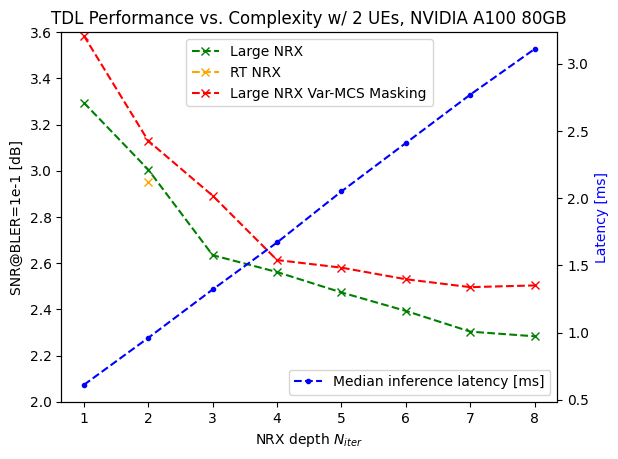

We can see that the RT NRX performance is current latency/compute-limited, as it is possible to achieve better SNR performance with more NRX iterations. While the performance improves significantly with another NRX iteration (three instead of two iterations), the performance gains flatten with four and more iterations. We can also see that the Large NRX architecture that supports dynamic adaptation of the number of iterations only shows a minor performance loss compared to the RT NRX that was trained solely for two iterations. Furthermore, we can see that the Var-MCS NRX comes with a minor SNR performance loss compared to the single-MCS Large NRX.

In summary, it is important to understand that the evaluation of a receiver architecture requires a careful consideration of 
the BLER performance, computational complexity, as well as the inference latency. 

## References

[1] S. Cammerer, F. Aït Aoudia, J. Hoydis, A Oeldemann, A Roessler, T. Mayer and A. Keller, "[A Neural Receiver for 5G NR Multi-user MIMO]((https://arxiv.org/pdf/2312.02601))", IEEE Workshops (GC Wkshps), Dec. 2023.
